In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import locale
import mibian
import numpy as np

In [2]:
# URL de la página a hacer scraping
url = 'https://www.meff.es/esp/Derivados-Financieros/Ficha/FIEM_MiniIbex_35'

# Realizar la petición HTTP GET a la página
response = requests.get(url)

In [3]:
def obtener_dataframe(response, tipo_tabla):
    """
    Realiza el web scraping y devuelve un dataframe con los datos obtenidos,
    dependiendo si el tipo de tabla es 'opciones' o 'futuros'.
    
    Args:
    - response: La respuesta HTTP obtenida.
    - tipo_tabla: Tipo de la tabla a buscar ('opciones' o 'futuros').
    
    Returns:
    - Un dataframe con los datos de la tabla.
    """
    # Determinar el ID de la tabla y si se necesita manejar el atributo data-tipo
    if tipo_tabla == 'opciones':
        id_tabla = 'tblOpciones'
        es_opcion = True
    elif tipo_tabla == 'futuros':
        id_tabla = 'Contenido_Contenido_tblFuturos'
        es_opcion = False
    else:
        print("Tipo de tabla no soportado.")
        return pd.DataFrame()
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', id=id_tabla)
        all_rows_data = []
        
        if table:
            rows = table.find_all('tr', class_='text-right')
            
            for row in rows:
                cells = row.find_all('td')
                row_data = [cell.text.strip() for cell in cells]
                
                if es_opcion:
                    data_tipo = row.get('data-tipo', 'No especificado')
                    row_data.insert(0, data_tipo)
                    
                all_rows_data.append(row_data)
                
            return pd.DataFrame(all_rows_data)
        else:
            print('No se encontró la tabla con el id especificado.')
            return pd.DataFrame()
    else:
        print('Error al realizar la petición HTTP:', response.status_code)
        return pd.DataFrame()

In [4]:
def tratar_dataframe(df, tipo_tabla):
    """
    Transforma el dataframe según si es de opciones o de futuros.
    
    Args:
    - df: Dataframe a transformar.
    - tipo_tabla: Tipo de la tabla ('opciones' o 'futuros').
    
    Returns:
    - Un dataframe transformado.
    """
    if tipo_tabla == 'opciones':
        # Especificar los nombres de columna para opciones
        df.columns = ['Class', 'Strike', 'Buy_ord', 'Buy_vol', 'Buy_price', 'Sell_price', 'Sell_vol', 'Sell_ord', 'Ult', 'Vol', 'Aper', 'Max.', 'Min.','Ant']
        df['Tipo'] = df['Class'].str[:3]
        df['Fecha'] = pd.to_datetime(df['Class'].str[3:], format='%Y%m%d').dt.strftime('%d-%m-%Y')
        df = df.drop(['Class'], axis=1)
        
        # Transformaciones adicionales para opciones
        df['Strike'] = df['Strike'].str.replace('.', '').str.replace(',', '.').astype(float)
        df['Ant'] = pd.to_numeric(df['Ant'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d-%m-%Y')
        
        # Seleccionando solo las columnas deseadas para opciones
        df = df.loc[:, ['Tipo', 'Fecha', 'Strike', 'Ant']]
        
    elif tipo_tabla == 'futuros':
        # Especificar los nombres de columna para futuros
        df.columns = ['Vencimiento', 'Tipo', 'Buy_ord', 'Buy_vol', 'Buy_price', 'Sell_price', 'Sell_vol', 'Sell_ord', 'Ult', 'Vol', 'Aper', 'Max.', 'Min.','Ant']
        
        # Configurar locale a español
        locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8' if locale.windows_locale is None else 'Spanish')
        df['Vencimiento'] = pd.to_datetime(df['Vencimiento'], format='%d %b %Y')
        df['Ant'] = pd.to_numeric(df['Ant'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        
        # Seleccionando solo las columnas deseadas para futuros
        df = df.loc[:, ['Vencimiento', 'Ant']]
        
    else:
        print("Tipo de tabla no soportado.")
        return pd.DataFrame()
    
    return df

In [37]:
# Opciones
df_opciones = obtener_dataframe(response, 'opciones')
df_opciones = tratar_dataframe(df_opciones, 'opciones')

In [38]:
# Futuros
df_futuros = obtener_dataframe(response, 'futuros')
df_futuros = tratar_dataframe(df_futuros, 'futuros')

In [52]:
# Crear copias de los DataFrames para las opciones call y put
df_calls = df_opciones[df_opciones['Tipo'] == 'OCE'].copy()
df_puts = df_opciones[df_opciones['Tipo'] == 'OPE'].copy()

In [53]:
price_sub = df_futuros.loc[0, 'Ant']
rfr = 0
dia_futuro = df_futuros.loc[0, 'Vencimiento']

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Función de Black-Scholes para calcular el precio de una opción
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Función para calcular la volatilidad implícita
def implied_volatility(option_type, market_price, S, K, T, r):
    objective = lambda sigma: (black_scholes_call(S, K, T, r, sigma) if option_type == 'OCE' else black_scholes_put(S, K, T, r, sigma)) - market_price
    try:
        # Intentamos encontrar la volatilidad implícita dentro de un rango ampliado
        return brentq(objective, 0.0001, 3.0)
    except ValueError:
        # Si no es posible, retornamos NaN o algún valor que indique falta de convergencia
        return np.nan

In [55]:
price_sub = df_futuros.loc[0, 'Ant']
rfr = 0
dia_futuro = df_futuros.loc[0, 'Vencimiento']
# Corrección en la línea para calcular T
T = (pd.to_datetime(dia_futuro) - pd.Timestamp.now()).days / 365.25

In [56]:
# Calcular volatilidad implícita para cada opción
df_calls['Volatilidad Implícita'] = [
    implied_volatility(row['Tipo'], row['Ant'], price_sub, row['Strike'], T, rfr) for index, row in df_calls.iterrows()
]

In [57]:
# Calcular volatilidad implícita para cada opción
df_puts['Volatilidad Implícita'] = [
    implied_volatility(row['Tipo'], row['Ant'], price_sub, row['Strike'], T, rfr) for index, row in df_puts.iterrows()
]

In [58]:
call_dates = {f"Fecha {i+1}": group for i, (name, group) in enumerate(df_calls.groupby('Fecha'))}
put_dates = {f"Fecha {i+1}": group for i, (name, group) in enumerate(df_puts.groupby('Fecha'))}

In [62]:
call_dates['Fecha 5']

,Tipo,Fecha,Strike,Ant,Volatilidad Implícita
62,OCE,2024-06-21,9900.0,903.0,0.297298
65,OCE,2024-06-21,10100.0,728.0,0.279696
68,OCE,2024-06-21,10500.0,410.0,0.243139
69,OCE,2024-06-21,10600.0,341.0,0.234570
71,OCE,2024-06-21,10700.0,276.0,0.224898
73,OCE,2024-06-21,10800.0,223.0,0.220571
74,OCE,2024-06-21,10900.0,179.0,0.218650


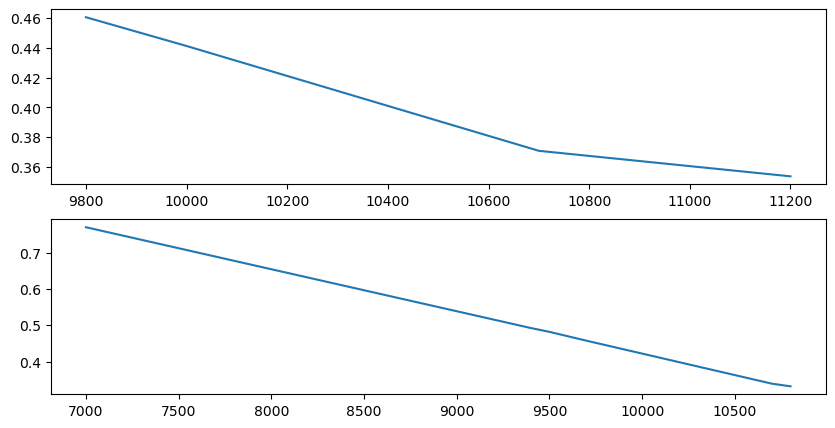

In [79]:
date = 6
fecha = f'Fecha {date}'

# Graficar Volatilidad Implícita en función de Strike
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(call_dates[fecha]['Strike'], call_dates[fecha]['Volatilidad Implícita'])
plt.subplot(2,1,2)
plt.plot(put_dates[fecha]['Strike'], put_dates[fecha]['Volatilidad Implícita'])

In [141]:
fechas = [dia for dia in resultados['Call'].keys()]

In [12]:
def volatilidad(row, precio_f, vencimiento_f, interest_rate):
    """
    Función para calcular la volatilidad implícita de una opción call.
    
    Parámetros:
    row (pd.Series): Fila del DataFrame que representa una opción.
    precio_f (float): Precio actual del activo subyacente obtenido de df_futuros.
    vencimiento_f (datetime.date or pd.Timestamp): Fecha de vencimiento del futuro obtenida de df_futuros.
    interest_rate (float): Tasa de interés libre de riesgo.

    Retorna:
    float: La volatilidad implícita de la opción call, o None si no es calculable.
    """
    if row.isna().any():
        return None
    else:
        precio_strike = row['Strike']
        vencimiento_c = row['Fecha']
        precio_c = row['Ant']

        # Asegúrate de que vencimiento_f y vencimiento_c son objetos de fecha
        if isinstance(vencimiento_f, pd.Timestamp):
            vencimiento_f = vencimiento_f.to_pydatetime().date()
        if isinstance(vencimiento_c, pd.Timestamp):
            vencimiento_c = vencimiento_c.to_pydatetime().date()

        # Calcula la diferencia de días como un número entero
        variacion_dias = (vencimiento_c - vencimiento_f).days
        if variacion_dias != 0:
            call = mibian.BS([precio_f, precio_strike, interest_rate, variacion_dias], callPrice=precio_c)
            return call.impliedVolatility
        else:
            return None

In [143]:
df_2 = df_calls.copy()
df_2 = df_2.reset_index(drop = True)

In [144]:
df_2 

,Tipo,Fecha,Strike,Ant
0,OCE,2024-04-19,8400.0,2244.0
1,OCE,2024-04-19,8500.0,2144.0
2,OCE,2024-04-19,8600.0,2044.0
3,OCE,2024-04-19,8700.0,1944.0
4,OCE,2024-04-19,8800.0,1844.0
...,...,...,...,...
853,OCE,2026-06-19,10700.0,857.0
854,OCE,2026-06-19,10800.0,814.0
855,OCE,2026-06-19,10900.0,772.0
856,OCE,2026-06-19,11000.0,731.0


In [13]:
# Obtiene los valores del DataFrame df_futuros
price_subyacente = df_futuros.loc[0, 'Ant']
rfr = 0
dia_futuro = df_futuros.loc[0, 'Vencimiento']

fecha_vencimiento = pd.Timestamp('2024-09-20 00:00:00')


variacion = (fecha_vencimiento - dia_futuro).days

#### **Función de mibian.BS**

Dataframe opciones: Strike, Precio de la opción y la fecha.

Dataframe futuros: underlying price (subyacente) y fecha

 - **underlying_price:** Precio subyacente, es el precio del futuro MINI IBEX al vencimiento más próximo.
 
 - **call price:** Es el precio de la opción, columna 'ANT'

 - **interest rate:** 0

 - **days to expiration:** Diferencia entre la fecha actual y la de vencimiento

In [16]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

def calculate_volatility(row):
    try:
        return volatilidad(row, price_subyacente, dia_futuro, rfr)
    except Exception as e:
        print(f"Error processing row: {e}")
        return None

def main():
    results = []
    for index, row in df_opciones.iterrows():
        result = calculate_volatility(row)
        results.append(result)
    

    df_opciones['Volatilidad Implícita'] = results
    print(df_opciones)

if __name__ == "__main__":
    main()

     Tipo      Fecha   Strike     Ant  Volatilidad Implícita
0     OPE 2024-04-19   8400.0     NaN                    NaN
1     OCE 2024-04-19   8400.0  2244.0                    NaN
2     OCE 2024-04-19   8500.0  2144.0                    NaN
3     OPE 2024-04-19   8500.0     NaN                    NaN
4     OPE 2024-04-19   8600.0     NaN                    NaN
...   ...        ...      ...     ...                    ...
1602  OPE 2025-06-20  13500.0  2900.0              83.221436
1603  OCE 2025-06-20  13500.0    27.0              12.619019
1604  OCE 2025-06-20  13600.0    23.0              12.557983
1605  OPE 2025-06-20  13600.0  2994.0              85.828781
1606  OCE 2025-12-19  12000.0   300.0              13.784409

[1607 rows x 5 columns]


In [18]:
df_opciones

,Tipo,Fecha,Strike,Ant,Volatilidad Implícita
0,OPE,2024-04-19,8400.0,NaN,NaN
1,OCE,2024-04-19,8400.0,2244.0,NaN
2,OCE,2024-04-19,8500.0,2144.0,NaN
3,OPE,2024-04-19,8500.0,NaN,NaN
4,OPE,2024-04-19,8600.0,NaN,NaN
...,...,...,...,...,...
1602,OPE,2025-06-20,13500.0,2900.0,83.221436
1603,OCE,2025-06-20,13500.0,27.0,12.619019
1604,OCE,2025-06-20,13600.0,23.0,12.557983
1605,OPE,2025-06-20,13600.0,2994.0,85.828781


Precio subyacente: 10644

In [19]:
vol_dates = {f"Fecha {i+1}": group for i, (name, group) in enumerate(df_opciones.groupby('Fecha'))}

In [21]:
vol_dates['Fecha 2'].tail(10)

,Tipo,Fecha,Strike,Ant,Volatilidad Implícita
348,OPE,2024-04-26,12300.0,1646.0,381.011963
349,OCE,2024-04-26,12300.0,NaN,NaN
350,OCE,2024-04-26,12400.0,NaN,NaN
351,OPE,2024-04-26,12400.0,1746.0,402.999878
352,OPE,2024-04-26,12500.0,1846.0,424.896240
353,OCE,2024-04-26,12500.0,NaN,NaN
354,OCE,2024-04-26,12600.0,NaN,NaN
355,OPE,2024-04-26,12600.0,1946.0,446.716309
356,OPE,2024-04-26,12700.0,2046.0,468.475342
357,OCE,2024-04-26,12700.0,NaN,NaN


In [22]:
import matplotlib.pyplot as plt

In [30]:
vol_dates['Fecha 2']

,Tipo,Fecha,Strike,Ant,Volatilidad Implícita
194,OCE,2024-04-26,9000.0,1650.0,59.204102
195,OPE,2024-04-26,9000.0,NaN,NaN
196,OPE,2024-04-26,9100.0,NaN,NaN
197,OCE,2024-04-26,9100.0,1550.0,55.786133
198,OCE,2024-04-26,9200.0,1451.0,53.833008
...,...,...,...,...,...
353,OCE,2024-04-26,12500.0,NaN,NaN
354,OCE,2024-04-26,12600.0,NaN,NaN
355,OPE,2024-04-26,12600.0,1946.0,446.716309
356,OPE,2024-04-26,12700.0,2046.0,468.475342


In [61]:
filtered_data = vol_dates['Fecha 2'][vol_dates['Fecha 2']['Tipo'] == 'OCE']

In [53]:
filtered_data = filtered_data.dropna()

In [50]:
filtered_data

,Tipo,Fecha,Strike,Ant,Volatilidad Implícita
473,OCE,2024-05-10,8900.0,1689.0,0.000010
474,OCE,2024-05-10,9000.0,1590.0,0.000010
477,OCE,2024-05-10,9100.0,1491.0,0.000010
478,OCE,2024-05-10,9200.0,1391.0,0.000010
480,OCE,2024-05-10,9300.0,1292.0,0.000010
482,OCE,2024-05-10,9400.0,1194.0,0.000010
484,OCE,2024-05-10,9500.0,1095.0,0.000010
486,OCE,2024-05-10,9600.0,997.0,0.000010
488,OCE,2024-05-10,9700.0,900.0,0.000010
490,OCE,2024-05-10,9750.0,852.0,0.000010


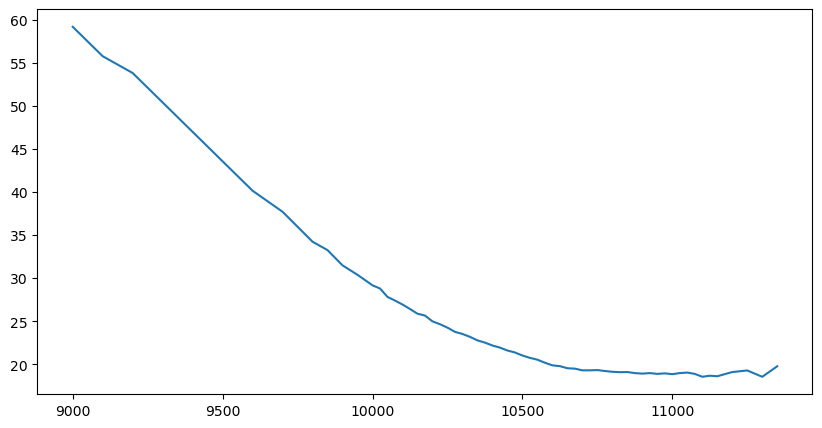

In [62]:
# Graficar Volatilidad Implícita en función de Strike
plt.figure(figsize=(10, 5))
plt.plot(filtered_data['Strike'], filtered_data['Volatilidad Implícita'])